In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

torch.manual_seed(1)

# Hyperparameters

In [2]:
#! Hyper Parameters
num_epochs = 10
batch_size = 8
learning_rate = 0.001

# Pre-processing

In [3]:
class SHM_Dataset(Dataset):
    """ Prepare dataset for pytorch
        Ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """

    def __init__(self, case, data_file,transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])): 
        self.case = case
        self.data_file = Path(data_file)
        self.data_df = pd.read_json(self.data_file, dtype=np.array)
        # self.data = self.data_df.cat()
        self.data = self.data_df.stack()
        self.labels = pd.DataFrame([self.case,]*self.data_df.shape[0]*self.data_df.shape[1])
        self.transform = transform
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        label = np.array(self.labels.iloc[index])
        feature = np.array(self.data.iloc[index])
        feature = self.transform(feature)
        # print(f"feature: {feature.shape}, label: {label.shape}")
        return feature, label


# shmDS = SHM_Dataset(1, "~/Codes/homework/data/SHM/shm01s.json")
# print("There is", len(shmDS), "samples in the given dataset")

In [4]:

shmDS_1 = SHM_Dataset(1, "~/Codes/homework/data/SHM/shm01s.json")
shmDS_2 = SHM_Dataset(2, "~/Codes/homework/data/SHM/shm02s.json")
shmDS_3 = SHM_Dataset(3, "~/Codes/homework/data/SHM/shm03s.json")
shmDS_4 = SHM_Dataset(4, "~/Codes/homework/data/SHM/shm04s.json")
shmDS_5 = SHM_Dataset(5, "~/Codes/homework/data/SHM/shm05s.json")
shmDS_6 = SHM_Dataset(6, "~/Codes/homework/data/SHM/shm06s.json")
shmDS_7 = SHM_Dataset(7, "~/Codes/homework/data/SHM/shm07s.json")
shmDS_8 = SHM_Dataset(8, "~/Codes/homework/data/SHM/shm08s.json")
shmDS_9 = SHM_Dataset(9, "~/Codes/homework/data/SHM/shm09s.json")
shmDS = shmDS_1 + shmDS_2 + shmDS_3 + shmDS_4 + shmDS_5 + shmDS_6 + shmDS_7 + shmDS_8 + shmDS_9

In [5]:
print("There is", len(shmDS_6), "samples in the given dataset")
# print(shmDS_6.__getitem__(11))

There is 3744 samples in the given dataset


Let's have a look on a single sample:

Feature batch shape: torch.Size([8, 1, 16, 16])
Labels batch shape: torch.Size([8, 1])


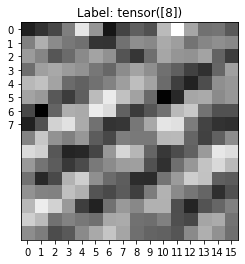

In [6]:
train_loader = DataLoader(shmDS, batch_size=batch_size, shuffle=True) # split samples into mini-batches and reshuffle the data to reduce overfitting
test_loader = DataLoader(shmDS, batch_size=batch_size, shuffle=False)

train_features, train_labels = next(iter(train_loader))
# train_features = train_features.unsqueeze(dim=1)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
fig, axis = plt.subplots()
axis.imshow(img, cmap="gray")

axis.set(title=f"Label: {label}", xticks=range(16), yticks=range(8))
plt.show()


# Build the neural network

## CNN Model

In [7]:
# Two-layer convolution
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Quick build with sequence tools
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32 * 1 * 1, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # print(x.shape)
        x = x.view(-1, 32 * 1 * 1) 
        # print(x.shape)
        x = self.fc(x)
        return x

cnn = CNN()

## Loss and Optimizer

In [8]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the model

In [9]:
for epoch in range(num_epochs):
    for i, (train_features, train_labels) in enumerate(train_loader):
        train_features = Variable(train_features)
        # images = images.unsqueeze(dim=1)
        train_features = train_features.float()
        train_labels = Variable(train_labels)
        # print(type(images), images)
        # print(type(labels), labels)
        # print("[ OK ] at this step") 

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(train_features)
        # loss = loss_func(outputs, labels)
        loss = loss_func(outputs, torch.max(train_labels, 1)[1])
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(shmDS) // batch_size, loss.item()))

Epoch [1/10], Iter [100/3084] Loss: 0.0355
Epoch [1/10], Iter [200/3084] Loss: 0.0093
Epoch [1/10], Iter [300/3084] Loss: 0.0048
Epoch [1/10], Iter [400/3084] Loss: 0.0042
Epoch [1/10], Iter [500/3084] Loss: 0.0021
Epoch [1/10], Iter [600/3084] Loss: 0.0015
Epoch [1/10], Iter [700/3084] Loss: 0.0012
Epoch [1/10], Iter [800/3084] Loss: 0.0009
Epoch [1/10], Iter [900/3084] Loss: 0.0009
Epoch [1/10], Iter [1000/3084] Loss: 0.0008
Epoch [1/10], Iter [1100/3084] Loss: 0.0006
Epoch [1/10], Iter [1200/3084] Loss: 0.0006
Epoch [1/10], Iter [1300/3084] Loss: 0.0004
Epoch [1/10], Iter [1400/3084] Loss: 0.0004
Epoch [1/10], Iter [1500/3084] Loss: 0.0003
Epoch [1/10], Iter [1600/3084] Loss: 0.0004
Epoch [1/10], Iter [1700/3084] Loss: 0.0003
Epoch [1/10], Iter [1800/3084] Loss: 0.0003
Epoch [1/10], Iter [1900/3084] Loss: 0.0002
Epoch [1/10], Iter [2000/3084] Loss: 0.0002
Epoch [1/10], Iter [2100/3084] Loss: 0.0001
Epoch [1/10], Iter [2200/3084] Loss: 0.0001
Epoch [1/10], Iter [2300/3084] Loss: 0.00

# Test the model

In [10]:
cnn.eval()  # Change to test form, application scenarios such as: dropout
correct = 0
total = 0
for test_features, test_labels in test_loader:
    test_features = Variable(test_features)
    # images = images.unsqueeze(dim=1)
    test_features = test_features.float()
    test_labels = Variable(test_labels)
    # print(x.shape)


    outputs = cnn(test_features)
    # print(outputs.type)
    _, predicted = torch.max(outputs.data, 0)
    # print(outputs.data)
    # print(predicted)
    predicted = predicted +1
    total += test_labels.size(0)
    # print('ok for this step', total)
    # print(test_labels.data)
    correct += (predicted == test_labels.data).sum()
    
    # print('okkkkkkkkkkkkkk for this step', correct)

print(' Test Accuracy: %d %%' % (100 * correct / total))

# Save the Trained Model
# torch.save(cnn.state_dict(), 'cnn.pkl')

 Test Accuracy: 174 %
